# Introduction
In the United States, elections play a crucial role in allowing the public to determine which candidates and their corresponding policies best represent it. Without elections, the government would be unable to enact policies that encompass the concerns of its citizens. However, despite the importance of elections, voter turnout is typically less than 70% across all levels of government. As a result, voter turnout may be a decisive factor in US elections due to the different strategies political parties implement to win them. For instance, while the Democratic Party typically relies on large city populations as its main voter base, the Republican Party relies on winning many non-urban regions with sparse populations. Therefore, we investigate whether party performance is related to voter turnout across different levels of government in the United States. Furthermore, we examine whether political parties perform uniformly across all levels of government within states and whether vote totals within a state affect party wins at certain levels. 

Our analysis found that voter turnout alone does not have a significant relationship with party performance across all levels of government. We observed that while Republican-won counties show a slightly higher mean turnout, the overall participation rate tends to be lower in more heavily populated counties. However, if other factors, such as population and geography, were taken into account along with voter turnout, we could obtain a more accurate insight into party performance. We also found that political parties do not perform uniformly across all levels of government due to state-level party differences, while vote totals within a state do not necessarily affect party wins at certain levels because of the varied relationship between turnout and voter share. The remainder of the report is as follows: We provide a detailed description of our data sets for our analysis. It will cover the contents of the election data. Then, we employ data cleaning and merging procedures to create a uniform data set for analysis. We then produce several descriptive plots to visualize the data and to help understand the relationship between party performance and voter turnout, followed by a discussion of our findings.

In [342]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics as stats
import numpy as np
import os

#presidential
pres_county = pd.read_csv("data/president_county_candidate.csv")

#senate
senate_county = pd.read_csv("data/senate_county.csv")
senate_county_candidate = pd.read_csv("data/senate_county_candidate.csv")
senate_state = pd.read_csv("data/senate_state.csv")

#population
state_pop = pd.read_csv("data/state_population.csv") 
#taken from https://data.census.gov/table/DECENNIALCD1182020.P1?q=Population+Total
county_pop = pd.read_excel("data/county_pop.xlsx") 
#taken from https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html

### Cleaning State and County Pop

Data tables:

In this project, we used several election-related datasets to analyze county- and state-level voting patterns in the United States of America. We used the president_county_candidate table (32178 rows), in which each row shows the total number of votes received by a presidential candidate within an individual county in a state, as well as the party of the candidate and whether or not he or she won; the senate_county table (3583 rows), where each row shows Senate votes by county and the percent of votes; the senate_county_candidate table (14126 rows), in which each row shows the state, county, candidate, party, and total vote number; and the state_population (organized by column: 50 states, District of Columbia and Puerto Rico) and county_population (3143 rows) tables, which provide population counts at state at county level. We imported pandas, matplotlib, statistics, numpy, and os. These datasets together allow us to look at how population characteristics relate to presidential and Senate election outcomes at county and state level.

Data cleaning:

Our cleaning process focused on preparing the election datasets so they could be compared across offices and across counties. First, we filtered each dataset to include only Democratic and Republican candidates, removing third-party and independent candidates to keep analyses consistent. We then standardized party labels into two categories (“DEM” and “REP”). Next, we calculated several derived variables used in our analysis, including county-level turnout (total_votes / population), each candidate’s vote share (candidate_votes / total_votes), and margin of victory in counties where a party won. We also checked for duplicated rows, dropped counties with missing or zero population values, and verified that vote totals exceeded candidate-level votes. Because column names and structures were mostly aligned across the raw files, no major renaming was required beyond unifying vote totals. These cleaning steps produced a set of election datasets which allows us to compare party performance and turnout across offices and geographic areas.


In [343]:
state_pop = state_pop.T
state_pop.columns = state_pop.iloc[0]
state_pop = state_pop.drop(state_pop.index[0]).reset_index()
state_pop.columns = ['state', 'population']
state_pop['population'] = state_pop['population'].str.replace(',', '').astype(int)

In [344]:
county_pop_cols= county_pop.columns
county_pop_cols = county_pop_cols[:2] 
#only keep first two cols
county_pop = county_pop[4:] 
#remove excess rows
county_pop = county_pop[county_pop_cols]
county_pop = county_pop.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)':'county', 'Unnamed: 1':'population'})
county_pop = county_pop.dropna()

In [345]:
county_pop['county'] = county_pop['county'].str.lstrip('.')
county_pop[['county', 'state']] = county_pop['county'].str.split(',', expand=True)
county_pop['state'] = county_pop['state'].str.strip()
county_pop['county'] = county_pop['county'].str.strip()
county_pop['county'] = county_pop['county'].str.lower()
county_pop['state'] = county_pop['state'].str.lower()
county_pop['population'] = county_pop['population'].astype('int')

### President and Voter Share

Merging data:

To combine information across election types, we merged county-level candidate files with their corresponding county summary files while keeping the structure of each election type consistent. For the presidential and governor datasets, the merge was done directly on shared geographic identifiers (state, county, and FIPS codes) without creating a separate county_id, since the original files were already aligned well enough for row-level matching. For Senate data, which is organized differently, we first merged the Senate county file with the Senate state totals using state, and then merged that result with the Senate candidate table by matching both state and county. After these steps, each election dataset contains one row per candidate with the appropriate vote totals and county information attached. These merged tables allow us to compute turnout, vote share, and margins of victory consistently across presidential and Senate elections.

In [346]:
pres_county['county'] = pres_county['county'].str.lower()
pres_county['state'] = pres_county['state'].str.lower()
pres_county = pres_county[(pres_county['party'] == 'DEM') | (pres_county['party'] == 'REP')]

In [347]:
pres_county = pres_county.merge(county_pop, on=['county', 'state'], how='left')
pres_county = pres_county.dropna()

In [348]:
pres_county = pres_county[pres_county['county'] != 'district of columbia']
pres_county['county_total_votes'] = pres_county.groupby(['state', 'county'])['total_votes'].transform('sum')
pres_county['vote_share'] = pres_county['total_votes'] / pres_county['county_total_votes']

In [349]:
pres_county['turnout'] = pres_county['county_total_votes'] / pres_county['population']
pres_county = pres_county[pres_county['won'] == True]

In [350]:
pres_county.describe()

,total_votes,population,county_total_votes,vote_share,turnout
count,3.043000e+03,3.043000e+03,3.043000e+03,3043.000000,3043.000000
mean,3.094824e+04,1.034345e+05,4.828328e+04,0.703882,0.486714
std,9.726042e+04,3.373890e+05,1.470081e+05,0.108195,0.081826
min,6.000000e+01,6.500000e+01,6.400000e+01,0.500121,0.161668
25%,3.777000e+03,1.081800e+04,5.183000e+03,0.615371,0.433645
50%,8.336000e+03,2.531600e+04,1.194900e+04,0.708987,0.488233
75%,2.096400e+04,6.665150e+04,3.155400e+04,0.791505,0.538552
max,3.028885e+06,1.001740e+07,4.174415e+06,0.968864,0.984615


The descriptive statistics for the 3,043 counties in this dataset reveal large variation in population size and total votes. County populations range from 65 residents to over 10 million, with a mean of ~103,000, but an extremely large standard deviation of ~337,000, meaning most counties are smaller with some very large outliers. Total votes follow a similar pattern. Vote share ranges from barely over 0.5 to over 0.96, with the middle half of counties falling between ~0.616 and ~0.791, showing that levels of support in counties vary considerably. Turnout ranged from just ~0.162 to more than 0.98 of the population; the mean turnout was about 0.487, and the standard deviation was about 0.08, demonstrating moderate variation with some extreme outliers.

In [351]:
pres_county['margin_of_victory'] = pres_county['vote_share'] - (1-pres_county['vote_share'])
dem_data = pres_county[pres_county['party'] == 'DEM']
rep_data = pres_county[pres_county['party'] == 'REP']

In [352]:
sampled_data = pres_county.sample(n=500, random_state=26)
dem_data = sampled_data[sampled_data['party'] == 'DEM']
rep_data = sampled_data[sampled_data['party'] == 'REP']

Plotting Relationships

### Figure 1. Vote Share vs Voter Turnout by Party (Presidential Elections)

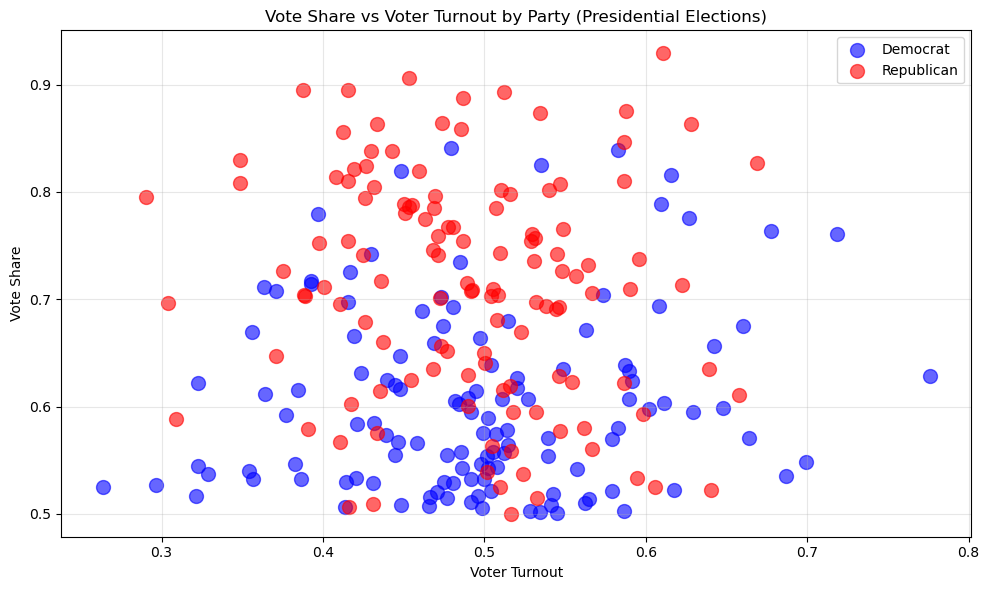

In [353]:
plt.figure(figsize=(10, 6))

dem_data = pres_county[pres_county['party'] == 'DEM'].sample(n=125, random_state=42)
rep_data = pres_county[pres_county['party'] == 'REP'].sample(n=125, random_state=42)

plt.scatter(dem_data['turnout'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turnout'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Vote Share vs Voter Turnout by Party (Presidential Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This figure visualizes how candidates’ vote shares relate to voter turnout within counties. For both parties, there is no strong linear relationship: counties with higher turnout do not consistently give either party higher vote shares. Instead, both Democratic and Republican vote shares appear widely distributed across turnout levels. This suggests that turnout alone does not systematically favor one party at the county level during presidential elections. Other factors, such as demographic composition or regional patterns, may play a larger role.


### Figure 2. Average Voter Turnout by Party (Counties Won)

C:\Users\pompo\AppData\Local\Temp\ipykernel_21228\3047651606.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_turnout_by_party = pres_county.groupby('party').apply(lambda x: np.average(x['turnout'], weights=x['population']))


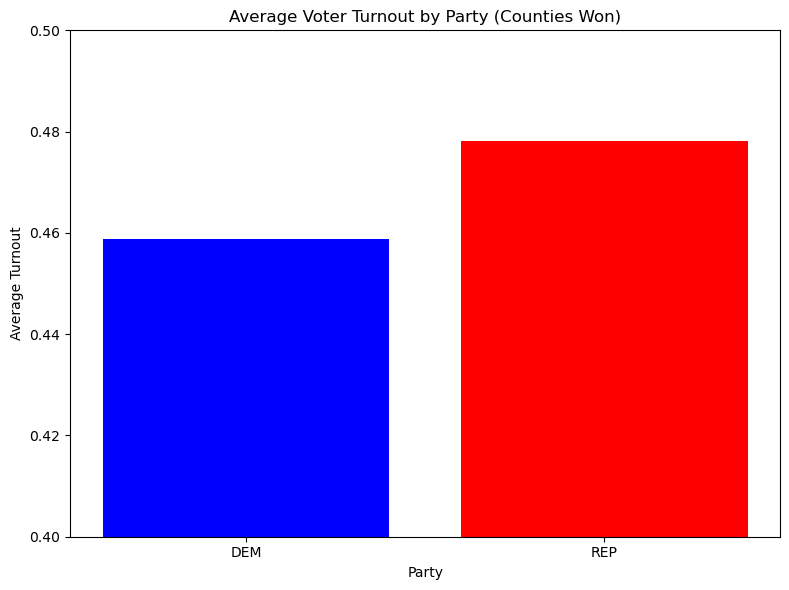

In [354]:
avg_turnout_by_party = pres_county.groupby('party').apply(lambda x: np.average(x['turnout'], weights=x['population']))

plt.figure(figsize=(8, 6))
plt.bar(avg_turnout_by_party.index, avg_turnout_by_party.values, color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Average Turnout')
plt.title('Average Voter Turnout by Party (Counties Won)')
plt.ylim(0.4, 0.5)
plt.tight_layout()
plt.show()

This bar chart compares average turnout in counties won by Democrats versus Republicans. Counties that voted Republican show a slightly higher mean turnout than those won by Democrats. While the difference is not large, it suggests that Republican victories tend to occur in places where a somewhat larger share of eligible voters participate. 


### Figure 3. Voter Turnout vs County Population (Presidential Elections)

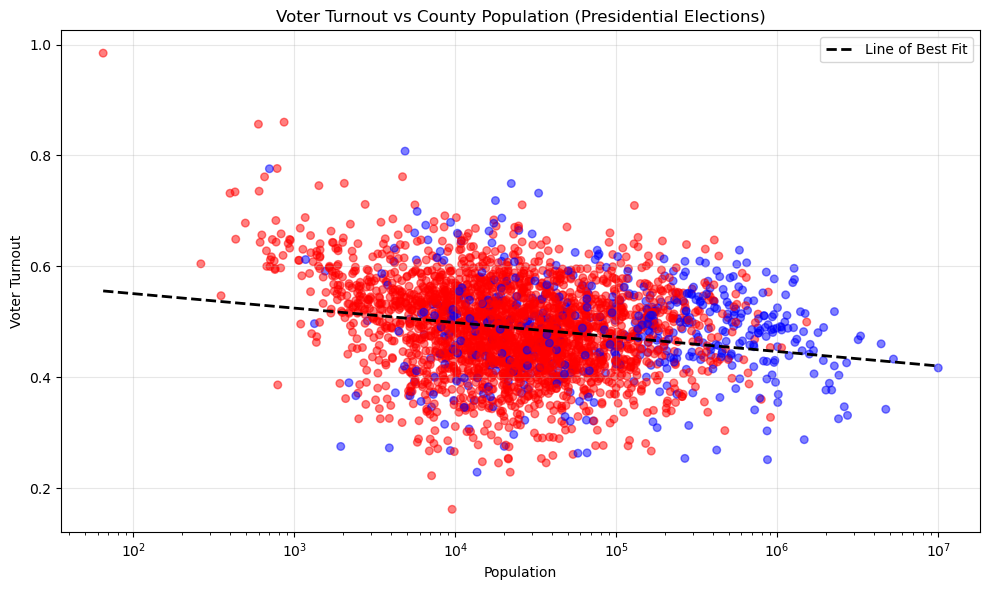

In [355]:
plt.figure(figsize=(10, 6))
plt.scatter(pres_county['population'], pres_county['turnout'], c=pres_county['party'].map({'DEM': 'blue', 'REP': 'red'}), alpha=0.5, s=30)
log_pop = np.log10(pres_county['population'])

#line of best fit
coefficients = np.polyfit(log_pop, pres_county['turnout'], 1)
poly = np.poly1d(coefficients)
x_line = np.linspace(log_pop.min(), log_pop.max(), 100)
y_line = poly(x_line)

plt.plot(10**x_line, y_line, color='black', linestyle='--', linewidth=2, label='Line of Best Fit')
plt.xlabel('Population')
plt.ylabel('Voter Turnout')
plt.title('Voter Turnout vs County Population (Presidential Elections)')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This figure shows how voter turnout varies with county population size during presidential elections. The log-scale on the x-axis lets us compare very small rural counties to the largest urban counties. While there is substantial variation in turnout across all population levels, the overall trend line slopes downward, indicating that turnout tends to be slightly lower in more populated counties. Both Democratic and Republican leaning counties appear throughout the turnout range, suggesting that population size influences participation rates more than it predicts which party wins. The broad scatter also shows that many other county-level factors, such as demographics or mobilization efforts, may have shaped turnout beyond population alone.


### Figure 4. Margin of Victory vs Voter Turnout by Party (Presidential Elections – Counties Won)

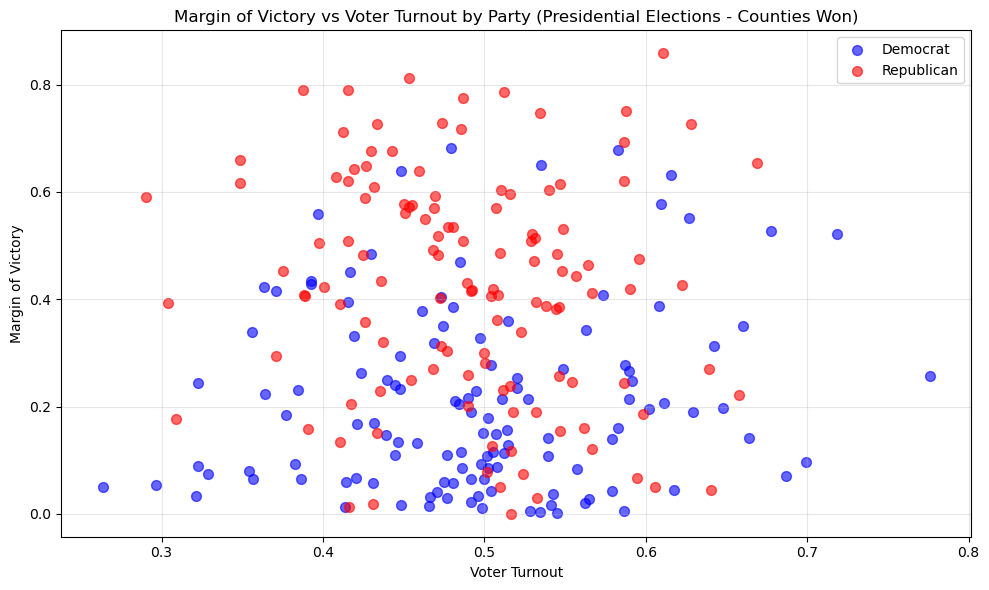

In [356]:
plt.figure(figsize=(10, 6))

plt.scatter(dem_data['turnout'], dem_data['margin_of_victory'], c='blue', label='Democrat', alpha=0.6, s=50)
plt.scatter(rep_data['turnout'], rep_data['margin_of_victory'], c='red', label='Republican', alpha=0.6, s=50)

plt.xlabel('Voter Turnout')
plt.ylabel('Margin of Victory')
plt.title('Margin of Victory vs Voter Turnout by Party (Presidential Elections - Counties Won)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This scatterplot compares voter turnout with the winning candidate’s margin of victory in each county. Each point represents the winning party in that county, colored by party. Overall, there is no strong monotonic relationship between turnout and margin of victory: counties with both high and low turnout can show either close races or landslide wins. The main takeaway is that turnout alone does not determine the competitiveness of a race. Counties with similar turnout levels can behave very differently depending on their political composition.


### Senate Vote Share

In [357]:
senate_county_candidate = senate_county_candidate[(senate_county_candidate['party'] == 'REP') | (senate_county_candidate['party'] == 'DEM')]
vote_state = senate_county_candidate.groupby(['state', 'party'])['total_votes'].sum().reset_index()
vote_state = vote_state.rename(columns={'total_votes': 'candidate_votes'})

vote_state = vote_state.merge(senate_state, how='right', on=['state'])
vote_state = vote_state.merge(state_pop, how='right', on=['state'])

vote_state['vote_share'] = (vote_state['candidate_votes'] / vote_state['total_votes'] * 2)
vote_state = vote_state.dropna()


In [358]:
vote_state['turn_out'] = vote_state['total_votes'] / vote_state['population']
pres_county['turnout'] = pres_county['county_total_votes'] / pres_county['population']


In [359]:
vote_state.describe()

,candidate_votes,total_votes,population,vote_share,turn_out
count,6.600000e+01,6.600000e+01,6.600000e+01,66.000000,66.000000
mean,5.570670e+05,2.639212e+06,5.589470e+06,0.392357,0.487142
std,6.168936e+05,2.289662e+06,5.460842e+06,0.218545,0.051159
min,2.773000e+03,2.708660e+05,5.768510e+05,0.013198,0.382359
25%,1.374128e+05,8.290938e+05,1.805064e+06,0.212963,0.459347
50%,2.616430e+05,2.134667e+06,4.505836e+06,0.379322,0.473844
75%,7.083740e+05,3.564136e+06,7.151502e+06,0.533635,0.523644
max,2.456123e+06,1.114404e+07,2.914550e+07,0.999563,0.601297


The descriptive statistics for the 2 parties in 33 states in this table show substantial variation in population, total votes, and total candidate votes. Populations range from 576851 to over 29 million, with a mean of 5.27 million. Total votes cast reflect this large variation in state population, ranging from 270,866 to more than 11 million, with a mean of 2.8 million. Vote share varies widely, from a minimum of just over 1 percent to near 100 percent, demonstrating that candidates exhibit extreme variation in popularity. Turnout is more stable across states, with the middle 50% of states falling between ~45 and ~52 percent turnout and no state falling below ~38 percent or above ~60 percent.

### Figure 5. Vote Share by State with Turnout Percentage as Circle Size (Senate Elections)

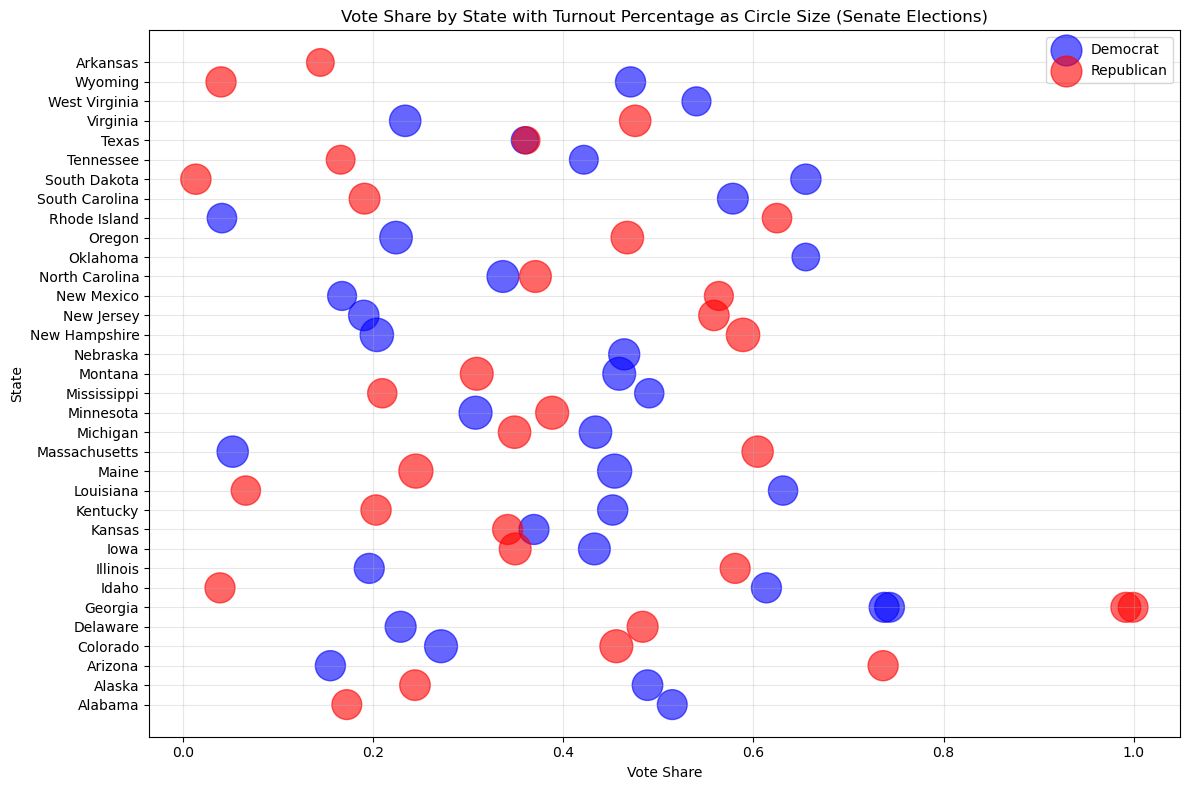

In [360]:
plt.figure(figsize=(12, 8))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

dem_sizes = dem_data['turn_out'] * 1000
rep_sizes = rep_data['turn_out'] * 1000

plt.scatter(dem_data['vote_share'], dem_data['state'], s=dem_sizes, c='blue', alpha=0.6, label='Democrat')
plt.scatter(rep_data['vote_share'], rep_data['state'], s=rep_sizes, c='red', alpha=0.6, label='Republican')

plt.xlabel('Vote Share')
plt.ylabel('State')
plt.title('Vote Share by State with Turnout Percentage as Circle Size (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This figure plots Democrat and Republican vote shares across states, with larger circles representing higher turnout levels. The distribution shows extreme variation in candidate vote share across states, but there is no evident strong relationship between turnout and vote share for either party. The figure suggests that state-level party differences rather than turnout is the main driver of vote share differences in Senate races.

### Figure 6. Voter Turnout vs Vote Share by Party (Senate Elections)

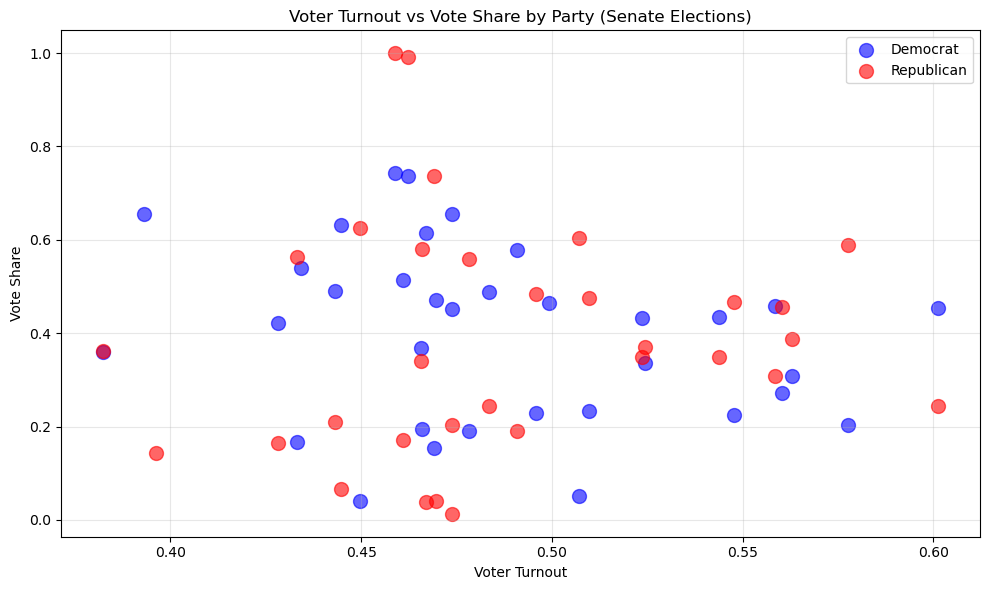

In [361]:
plt.figure(figsize=(10, 6))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

plt.scatter(dem_data['turn_out'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turn_out'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Voter Turnout vs Vote Share by Party (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This scatterplot examines how voter turnout is associated with vote share for both parties. The points for Democrat and Republican votes overlap substantially, demonstrating no clear trend suggesting that higher turnout consistently benefits one party more than the other. Vote shares seem to vary widely at every turnout level, showing that turnout alone is not a reliable predictor of Senate election outcomes.

In [362]:
vote_state_win = vote_state.loc[vote_state_win.groupby(['state'])['vote_share'].idxmax()]

### Figure 7. Voter Turnout vs Vote Share by Winning Party (Senate Elections)

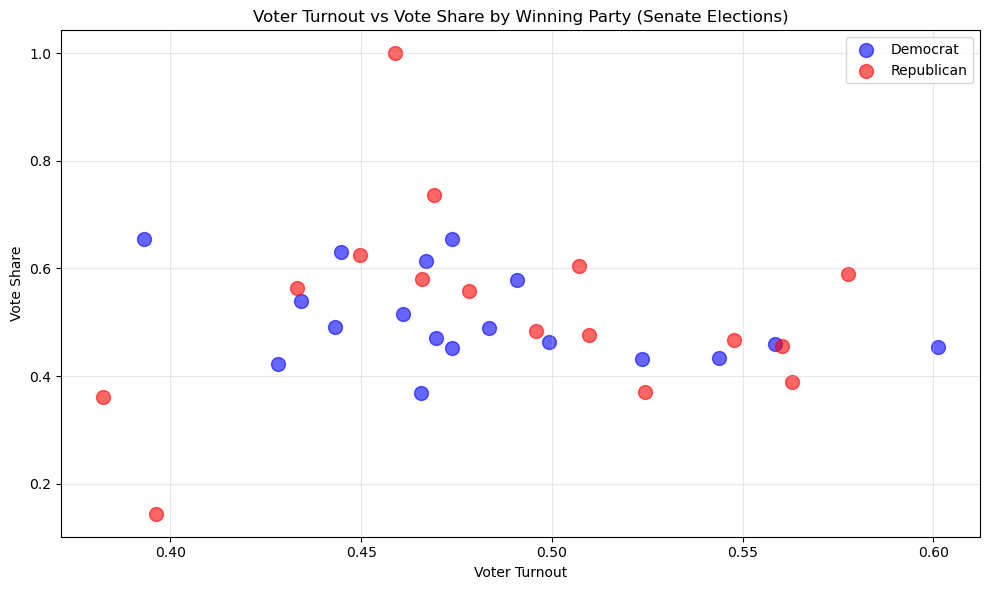

In [363]:
plt.figure(figsize=(10, 6))

dem_data = vote_state_win[vote_state_win['party'] == 'DEM']
rep_data = vote_state_win[vote_state_win['party'] == 'REP']

plt.scatter(dem_data['turn_out'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turn_out'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Voter Turnout vs Vote Share by Winning Party (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This scatterplot examines how voter turnout is associated with vote share for the winning party. Once again, the points for Democrat and Republican votes overlap substantially, demonstrating no clear trend suggesting that higher turnout benefits one winning party (Democrat or Republican) more than the other. Vote shares vary widely at all turnout levels, further suggesting that turnout alone is not a reliable predictor of Senate election outcomes.

### Figure 8. Number of States Won by Party (Senate Elections)

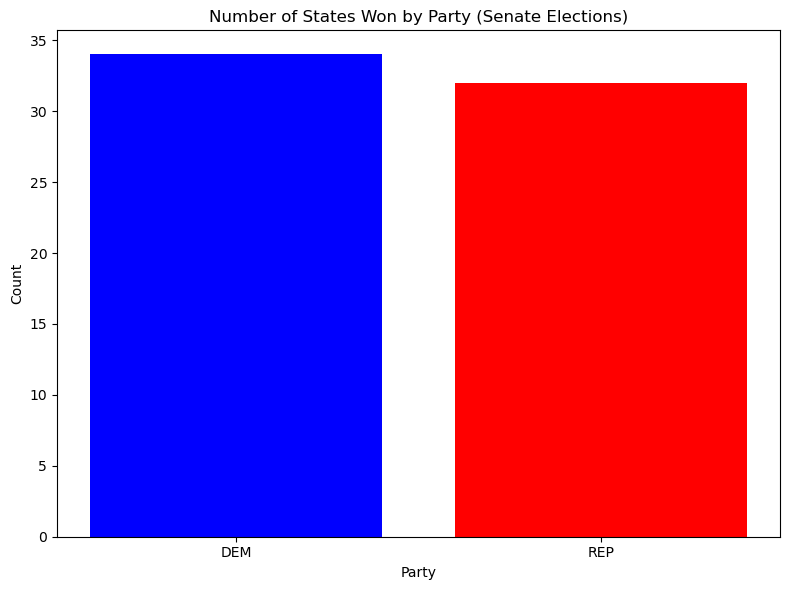

In [364]:
party_counts = vote_state['party'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(party_counts.index, party_counts.values, color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Count')
plt.title('Number of States Won by Party (Senate Elections)')
plt.tight_layout()
plt.show()

This bar chart compares the number of states won by Democrats and Republicans. The taller Democrat bar indicates that Democrats won more states overall. The figure illustrates a simple partisan imbalance in US senate victories.

# Conclusion and Discussion
The primary result of our investigation was that voter turnout alone does not have a significant relationship with party performance across all levels of government. Instead, party success in elections appears to be linked to contextual factors, such as population and geography, which were taken into account along with voter turnout, as indicated by the non-uniform performance of political parties across all levels of government. Future analyses of this relationship should incorporate more regionally in-depth variables, like demographics, to gain an enhanced understanding of the determinants of voter political party performance. Additionally, the senate_county_candidate dataset's "county" column appears to show many towns (not just counties), which may influence future analysis, so researchers must be careful with this dataset.